## Analysis on Dual Thresholds

### Author: Deb Debnath

### Motivation

As part of a discussion with Dr. Sninsky, it could be viable to set two thresholds instead of one for determining prognosis based on the classifier predictions.
The new thresholds are
1. 85% probability of Alzheimer's, i.e. probability score = 0.85
2. 85% probability of being NCI (non-cognitively impaired), i.e score = 0.15

Interpretation of this classification scheme would be
1. **High probability of AD category (Probably AD)** - Seek timely professional medical care for therapy including more aggressive hypertension, diabetes type 2 and obesity therapies as well as amyloid monoclonal antibodies
2. **Intermediate category (Intermediate)** - Self-guided comorbidity risk care (e.g. hypertension, T2 diabetes and obesity), exercise, hearing aids, cognitive engagement with testing in 6 months
3. **High probability of NCI category (Probably NCI)** - Testing in 6 months

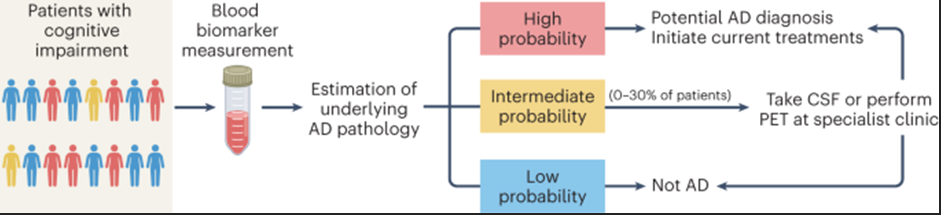

Reference table from _Wimo et al (2014)_
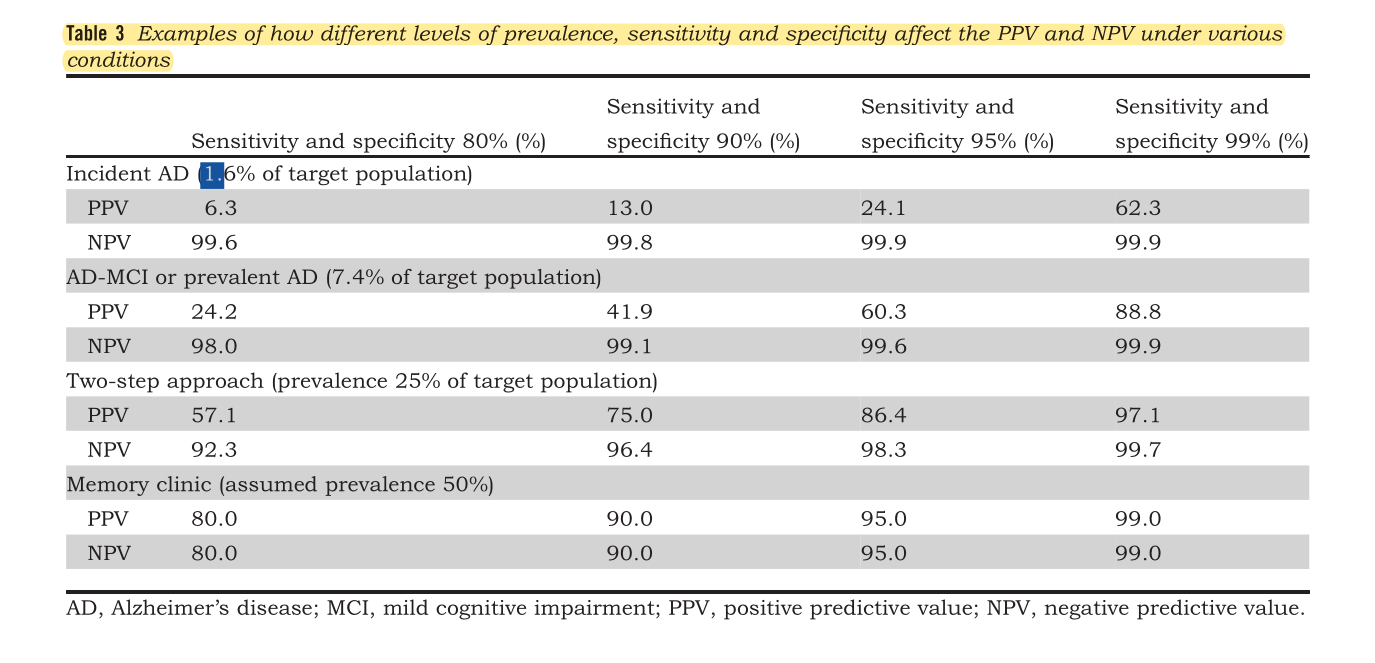

#### Data loading

In [137]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from src.threshold import plot_uncertainty_at_threshold, plot_v_plot
from src.classifier import z_score, linear_classifier_score, antilogit_classifier_score, sample_single_patient

In [139]:
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
pathos = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)

In [140]:
pathos = pathos.set_index("Isolate ID")
raw_data = raw_data.set_index("gene_id")

#### Setting parameters

In [141]:
mean_TPM = 0

In [142]:
num_patients = 243
num_runs = 1000
uncertainty = 50

In [143]:
thres_1, thres_2 = 0.15, 0.85

In [144]:
seed = 321

In [145]:
np.random.seed(seed)

#### Data preprocessing

In [146]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex=r"^\d+")
genes = patients_df.index.values

In [147]:
grouped_cols = patients_df.columns.str.split("-").str[0]
grouped = patients_df.groupby(grouped_cols, axis=1)
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
patients_df.index = genes

#### Conversion to Z-scores and dropping genes below TPM threshold

In [148]:
means = patients_df.mean(axis=1)
stds = patients_df.std(axis=1)

In [149]:
z_scores_df = patients_df.apply(lambda x: z_score(x, means, stds))

In [150]:
z_scores_df = z_scores_df[means >= mean_TPM]
coefficients = coefficients[means >= mean_TPM]

## Dual threshold experiments

#### Simulations

In [15]:
gt_list, preds_list = [], []
ad_diff_cls, int_diff_cls, nci_diff_cls = 0, 0, 0
for i in range(num_patients):
    col = z_scores_df.iloc[:, i]
    y_data = sample_single_patient(col, coefficients, num_runs, uncertainty)
    y_0 = antilogit_classifier_score(linear_classifier_score(coefficients, col))
    x_data = np.ones_like(y_data) * y_0
    
    if y_0 < thres_1:
        gt_label = 0
    elif thres_1 <= y_0 < thres_2:
        gt_label = 1
    else:
        gt_label = 2
    
    preds = np.zeros(num_runs, dtype=np.int64)
    preds[(thres_1 <= y_data) & (y_data < thres_2)] = 1 
    preds[y_data >= thres_2] = 2

    if gt_label == 0 and (1 in preds or 2 in preds):
        nci_diff_cls += 1
    elif gt_label == 1 and (0 in preds or 2 in preds):
        int_diff_cls += 1
    elif gt_label == 2 and (0 in preds or 1 in preds):
        ad_diff_cls += 1
        
    gt_arr = np.ones(num_runs, dtype=np.int64) * gt_label
    gt_list.append(gt_arr)
    preds_list.append(preds)

In [16]:
preds_all = np.hstack(preds_list)
gt_all = np.hstack(gt_list)

## Analysis of results

### Confusion matrix

In [17]:
cnf_mat = confusion_matrix(gt_all, preds_all)

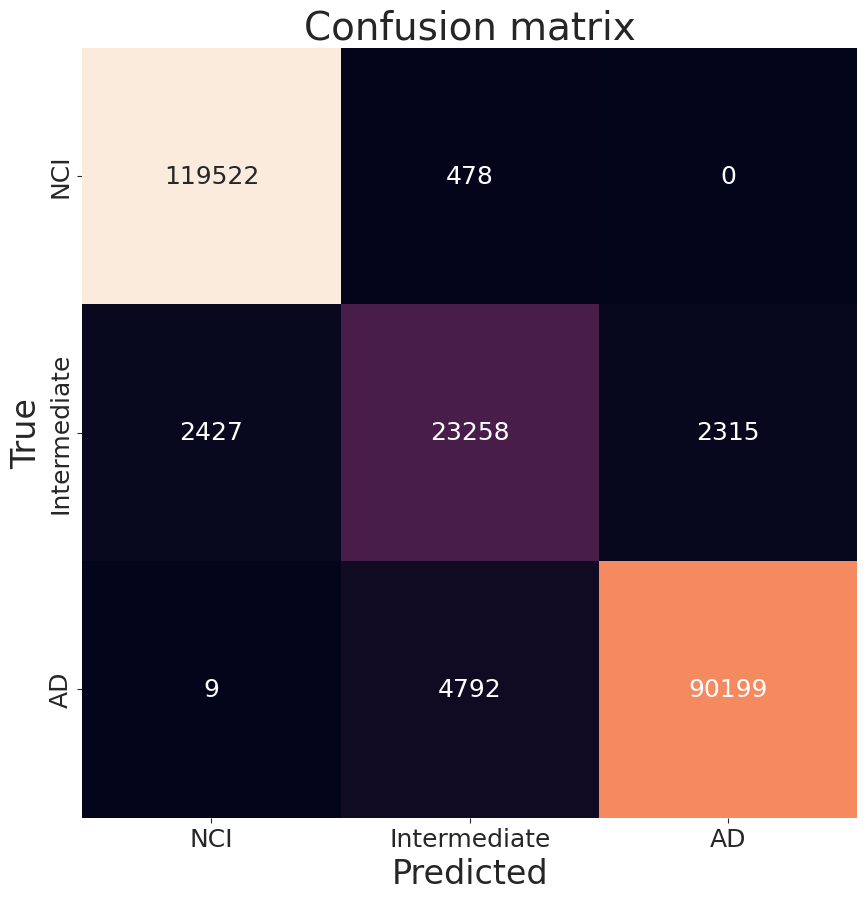

In [18]:
cnf_mat_df = pd.DataFrame(cnf_mat.astype(np.int64), index=["NCI", "Intermediate", "AD"], columns=["NCI", "Intermediate", "AD"])
plt.figure(figsize=(10, 10))
plt.title("Confusion matrix", fontsize=28)
sns.heatmap(cnf_mat_df, annot=True, cbar=False, fmt="g", annot_kws={"size": 18})
plt.tick_params(labelsize=18)
plt.xlabel("Predicted", fontsize=24)
plt.ylabel("True", fontsize=24)
plt.show()

## Sensitivity and Specificity

#### Metrics for AD classification

In [19]:
ad_tp = cnf_mat[2, 2]
ad_tn = np.sum(cnf_mat[:2, :2])
ad_fp = np.sum(cnf_mat[:2, 2])
ad_fn = np.sum(cnf_mat[2, :2])

In [20]:
sensitivity_AD = ad_tp / (ad_tp + ad_fn)
specificity_AD = ad_tn / (ad_tn + ad_fp)
ppv_AD = ad_tp / (ad_tp + ad_fp)
npv_AD = ad_tn / (ad_tn + ad_fn)

In [21]:
print("Alzheimer's disease classification:")
print(f"\tSensitivity: {sensitivity_AD:.4f}")
print(f"\tSpecificity: {specificity_AD:.4f}")
print(f"\tPPV: {ppv_AD:.4f}")
print(f"\tNPV: {npv_AD:.4f}")

Alzheimer's disease classification:
	Sensitivity: 0.9495
	Specificity: 0.9844
	PPV: 0.9750
	NPV: 0.9681


#### Metrics for NCI classification

In [22]:
nci_tp = cnf_mat[0, 0]
nci_tn = np.sum(cnf_mat[1:, 1:])
nci_fp = np.sum(cnf_mat[1:, 0])
nci_fn = np.sum(cnf_mat[0, 1:])

In [23]:
sensitivity_NCI = nci_tp / (nci_tp + nci_fn)
specificity_NCI = nci_tn / (nci_tn + nci_fp)
ppv_NCI = nci_tp / (nci_tp + nci_fp)
npv_NCI = nci_tn / (nci_tn + nci_fn)

In [24]:
print("NCI classification:")
print(f"\tSensitivity: {sensitivity_NCI:.4f}")
print(f"\tSpecificity: {specificity_NCI:.4f}")
print(f"\tPPV: {ppv_NCI:.4f}")
print(f"\tNPV: {npv_NCI:.4f}")

NCI classification:
	Sensitivity: 0.9960
	Specificity: 0.9802
	PPV: 0.9800
	NPV: 0.9961


### All metrics

In [25]:
from IPython.display import Markdown, display

In [26]:
string = f"""
| **Metric**    | **AD (%)** | **NCI (%)** |
|---------------|------------|-------------|
| Sensitivity   | {sensitivity_AD * 100:.2f} | {sensitivity_NCI * 100:.2f}|
| Specificity   | {specificity_AD * 100:.2f} | {specificity_NCI * 100:.2f} |
| PPV           | {ppv_AD * 100:.2f} | {ppv_NCI * 100:.2f} |
| NPV           | {npv_AD * 100:.2f} | {npv_NCI * 100:.2f} |
"""
display(Markdown(string))


| **Metric**    | **AD (%)** | **NCI (%)** |
|---------------|------------|-------------|
| Sensitivity   | 94.95 | 99.60|
| Specificity   | 98.44 | 98.02 |
| PPV           | 97.50 | 98.00 |
| NPV           | 96.81 | 99.61 |


### Differential Classification

A **differentially classified subject** is a subject (patient) that has one or more simulated scores that produced a different classification into AD/NCI than the actual score.

In [27]:
print(f"{ad_diff_cls / num_patients * 100:.2f} % simulated subjects were differentially classified from the Alzheimer's disease category.")
print(f"{int_diff_cls / num_patients * 100:.2f} % simulated subjects were differentially classified from the intermediate category.")
print(f"{nci_diff_cls / num_patients * 100:.2f} % simulated subjects were differentially classified from the NCI category.")

12.76 % simulated subjects were differentially classified from the Alzheimer's disease category.
11.52 % simulated subjects were differentially classified from the intermediate category.
5.76 % simulated subjects were differentially classified from the NCI category.


### Misclassifications

In [28]:
print(f"Fraction of simulated subjects differentially classified: Approximately {(ad_diff_cls + int_diff_cls + nci_diff_cls) / num_patients * 100:.2f}%")
print(f"Total number of differentially classified individuals: {(ad_diff_cls + int_diff_cls + nci_diff_cls)}")

Fraction of simulated subjects differentially classified: Approximately 30.04%
Total number of differentially classified individuals: 73


## Single threshold experiments

#### Setting parameters

In [29]:
thres = 0.15

#### Simulations

In [30]:
gt_list, preds_list = [], []
ad_diff_cls_1, nci_diff_cls_1 = 0, 0
for i in range(num_patients):
    col = z_scores_df.iloc[:, i]
    y_data = sample_single_patient(col, coefficients, num_runs, uncertainty)
    y_0 = antilogit_classifier_score(linear_classifier_score(coefficients, col))
    x_data = np.ones_like(y_data) * y_0
    
    gt_label = 0 if y_0 < thres_1 else 1
    
    preds = np.zeros(num_runs, dtype=np.int64)
    preds[(thres <= y_data)] = 1 

    if gt_label == 0 and 1 in preds:
        ad_diff_cls_1 += 1
    if gt_label == 1 and 0 in preds:
        nci_diff_cls_1 += 1
    
    gt_arr = np.ones(num_runs, dtype=np.int64) * gt_label
    gt_list.append(gt_arr)
    preds_list.append(preds)

In [31]:
preds_all = np.hstack(preds_list)
gt_all = np.hstack(gt_list)

## Analysis of results

In [32]:
cnf_mat = confusion_matrix(gt_all, preds_all)

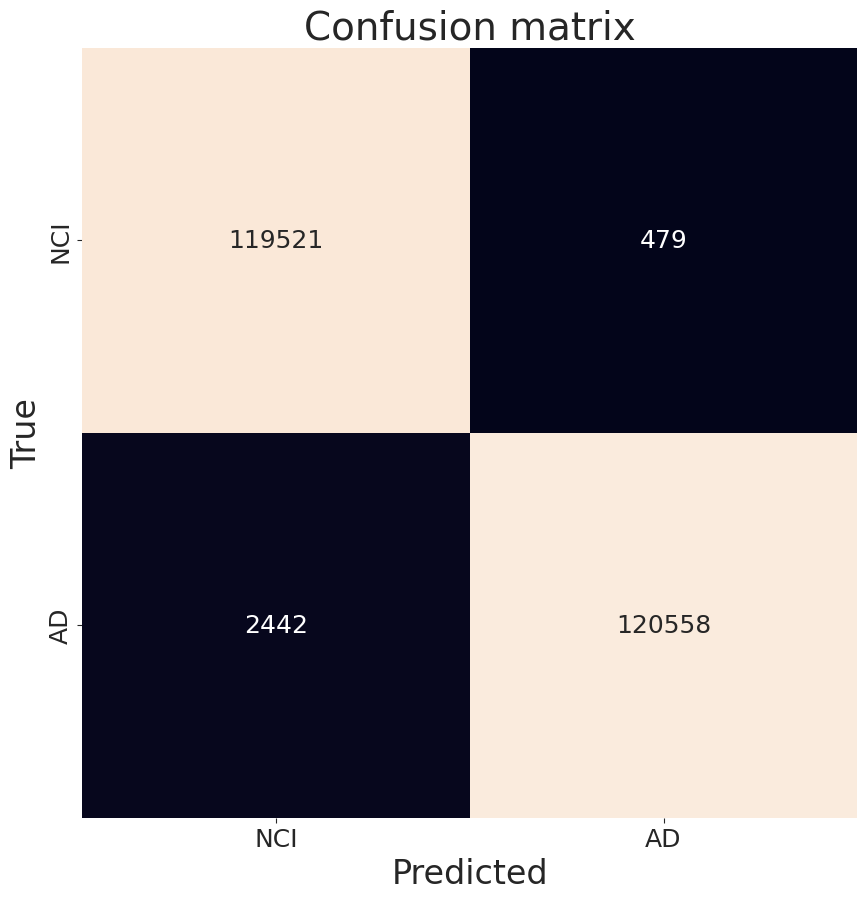

In [33]:
cnf_mat_df = pd.DataFrame(cnf_mat.astype(np.int64), index=["NCI", "AD"], columns=["NCI", "AD"])
plt.figure(figsize=(10, 10))
plt.title("Confusion matrix", fontsize=28)
sns.heatmap(cnf_mat_df, annot=True, cbar=False, fmt="g", annot_kws={"size": 18})
plt.tick_params(labelsize=18)
plt.xlabel("Predicted", fontsize=24)
plt.ylabel("True", fontsize=24)
plt.show()

In [34]:
print(f"{ad_diff_cls_1 / num_patients * 100:.2f} % simulated subjects were differentially classified from the Alzheimer's disease category.")
print(f"{nci_diff_cls_1 / num_patients * 100:.2f} % simulated subjects were differentially classified from the NCI category.")
print(f"{(ad_diff_cls_1 + nci_diff_cls_1) / num_patients * 100:.2f} % simulated subjects were differentially classified between AD and NCI categories.")
print(f"Total number of differentially classified individuals: {(ad_diff_cls_1 + nci_diff_cls_1)}")

5.76 % simulated subjects were differentially classified from the Alzheimer's disease category.
9.88 % simulated subjects were differentially classified from the NCI category.
15.64 % simulated subjects were differentially classified between AD and NCI categories.
Total number of differentially classified individuals: 38


- Verify assumptions, how to incorporate into code.
- Assumed Gaussian distribution as opposed to negative binomial. (Actual distribution is a mix of the two)
- Use Gaussian for the manuscript, but also consider a gene-specific distribution.

#### Figures

- V-plot
- Cluster plot

## Repeating above experiments but with the Best fit Probability Distribution for each Gene

From discussions it is suggested that TPM counts for each individual gene follow a negative binomial distribution, characterized by

$$
f(k; r, p) \equiv P(X = k) = \binom{k+r-1}{k} (1-p)^{k} p^{k}
$$

where

- $r$ > 0 — number of successes until the experiment is stopped (integer)
- $p$ ∈ $[0,1]$ — success probability in each experiment (real)

From Sam's email:

&nbsp;&nbsp;&nbsp;&nbsp;In regards to gene distributions from the Science Advances dataset, a quick analysis revealed:

- Negative Binomial Distribution: The computational analysis (run in a Jupyter Python notebook) confirmed the majority of the genes in this TPM RNA-Seq dataset fit a negative binomial distribution. This is supported by the p-value threshold of 0.10 applied in the Kolmogorov-Smirnov test.  Approximately 61% of genes in the AD dataset and 77% in the NCI dataset fit this distribution. This provides strong evidence that the negative binomial model is appropriate for modelling the variability in the RNA-Seq data. 

- Negative Binomial Distribution ~ Details on Process, already shared with JS:
    The process looks something like this:
  - We use the Kolmogorov-Smirnov Test to compare the empirical distribution of the data with the theoretical distribution (in this case, we nominate the negative binomial distribution).
  - We calculate a p-value which tells us the probability that the observed data could come from the theoretical distribution.
  - In the code, we set the p-value threshold at 0.10. We interpret it like so; if the p-value is greater than 0.10, it means the gene's expression values do not significantly differ from a negative binomial distribution. Thus, we consider the gene to fit the negative binomial distribution. Conversely, if the p-value is less than or equal to 0.10, it means the gene's expression values do significantly differ from the negative binomial distribution, and we consider the gene to not fit the negative binomial distribution.
  - We have provided the html output for reference, listing the p-values; a boolean of whether neg binomial or not;TPM mean;TPM median. Then we calculate the percentage and count of genes that fit the negative binomial distribution per pathology.  Would you like to look at this now from the perspective of setting a TPM threshold to investigate whether there is a relationship between high/low TPM and distribution type?
  - For quick reference: NCI - Percentage of genes in df_NCI that fit the negative binomial distribution: 77.75%. NCI - Count of genes in df_NCI that fit the negative binomial distribution: 720. AD - Percentage of genes in df_AD that fit the negative binomial distribution: 61.02%. AD - Count of genes in df_AD that fit the negative binomial distribution: 565.
  - Also attached are 2 pdf's (AD and NCI) of all gene distributions as a reference of sorts (raw data plots).
  - Please note a TPM mean of 3 filtered the original dataframe.
- High or low TPM associations with distribution type:
  - AD Dataset:
    - Genes with mean TPM ≤ 10 that are negative binomial: 84
    - Genes with mean TPM ≥ 10 that are negative binomial: 481
    - Genes with mean TPM ≤ 10 that are not negative binomial: 194
    - Genes with mean TPM ≥ 10 that are not negative binomial: 167
  - NCI Dataset:
    - Genes with mean TPM ≤ 10 that are negative binomial: 146
    - Genes with mean TPM ≥ 10 that are negative binomial: 574
    - Genes with mean TPM ≤ 10 that are not negative binomial: 117
    - Genes with mean TPM ≥ 10 that are not negative binomial: 89
- Other Distributions for AD Dataset: Among the genes that did not fit the negative binomial distribution, the following distributions were identified:
  - Normal Distribution: 90 genes
  - Exponential Distribution: 142 genes
  - Gamma Distribution: 156 genes
  - Log-Normal Distribution: 104 genes
  - Poisson Distribution: 0 genes
  - None*: 75 genes
- Other Distributions for NCI Dataset: Among the genes that did not fit the negative binomial distribution, the following distributions were identified:
  - Normal Distribution: 175 genes
  - Exponential Distribution: 177 genes
  - Gamma Distribution: 110 genes
  - Log-Normal Distribution: 39 genes
  - Poisson Distribution: 0 genes
  - None*: 66 genes

Following up with a first pass on the concordance/discordance data:

- The concordant/discordant distribution rate across 926 genes show the following between AD and NCI :

    - No of Concordant Negative Binomial Distribution: 506
    - No of Concordant Non-Negative Binomial Distribution: 147
    - No of Discordant Non-Negative Binomial in AD and Neg Binomial in NCI : 214
    - No of Discordant Negative Binomial in AD and Non-Negative Binomial in NCI : 59

- Of those genes above, when the next set of distributions were tested (i.e those which are not negative binomial (n=331)) this is the concordant/discordant breakdown. It does not include those in the 'none' category of distributions:

    - No of Concordant Distributions between AD and NCI: 135
    - No of Discordant Distributions between AD and NCI: 196


From the information provided above, 506 genes, or > 50% of the genes in both AD and NCI datasets conform to the negative binomial distribution. On the basis of this finding, we have the following options in modeling the uncertainty of genes
1. fit the negative binomial distribution to all genes.
2. fit each gene to its own (suggested) distribution.

Additionally, to simulate measurement uncertainty with a given degree, we can use $\mu =X$ and $\sigma = 0.1 X$, calculating the parameters for the negative binomial distribution ($r, p$) from $\mu$ and $\sigma$ as

$$
r = \frac{\mu^2}{\sigma^{2}-\mu}, \\
p = \frac{\mu}{\sigma^2}
$$

Possible approaches to model uncertainty (Sam):
1. Use the Full Unfiltered Data Matrix with Only Rounding: Start with the unfiltered df2_t, keeping raw TPM values and apply only rounding, so no transformations or filtering. TPM data combines biological and technical variability, resulting in large variances (e.g., 8391.04 for ENSG00000079482.12), and preserving these ensures the classifier, trained on this full range including low-expression genes, is tested against realistic variability.
    
2. Fit a Distribution to Each Gene’s TPM Values: Analyze the ~234 TPM values per gene in the unfiltered df2_t to determine its best-fitting distribution, such as negative binomial, log-normal, or gamma etc. The added noise thus mimics the gene’s natural variability pattern. This ensures the noise challenges the classifier’s probability estimates by reflecting each gene’s unique behavior, like the overdispersion seen in VMR results (e.g., 140.4 for ENSG00000079482.12).

3. Run the separate simulations with 10%, 20%, and 50% noise levels: Set the three noise levels (we should also consider adding 30%), and run the separate Monte Carlo simulations to generate new TPM values that flip the classifier predictions. We need to explore two options: 
    a) per-gene, sampling all ~234 values in a gene’s column from a distribution set by its average TPM (e.g., 59.77 for ENSG00000079482.12), or 
    b) per-cell, sampling each patient’s TPM  from a distribution scaled to that value, adjusted for larger shifts if needed. 
    
I have been mulling whether (a) or (b) best captures variability and precision. For approach (a) it’s like a single cookie cutter approach for the whole group where everyone’s new TPM count will be based on the group average, not their own starting point. This worries me as it does meet the per-analyte precision test requirements but misses the "different combinations" simulation depth as requested by the FDA. For (b) it is a more specific approach for each subject's TPM. It’s more work, but it keeps the starting TPM in mind, making the changes more unique to the subject. Note, that we still need to test the distribution in principle 2 e.g., log-normal as it is used in both a and b, rather just applied differently.

## How do we add noise for a given distribution?

We are provided with the % uncertainty we want to simulate using noise, say $k$ ($0 \le k \le 1$), such that for a measurement $X$, the mean is $X$ and standard deviation is $kX$.

## Discrete distributions

#### 1. Poisson distribution

For a Poisson distribution the relative uncertainty (i.e. the standard deviation divided by the mean) is

$$
\frac{\sigma}{\mu} = \frac{\sqrt{\lambda}}{\lambda} = \frac{1}{\sqrt{\lambda}}.
$$

So if we want a relative uncertainty of $k$, we need

$$
\frac{1}{\sqrt{\lambda}} = k \quad \Longrightarrow \quad \lambda = \frac{1}{k^2}.
$$

To achieve this we sample from a Poisson distribution with $\lambda = \frac{1}{k^2}$.  Then we scale each value by $\frac{X}{1/k^2} = Xk^2$ so that the final samples have a mean $X$ and standard deviation $kX$.

#### 2. Negative binomial distribution

For a negative binomial distribution $NB(r, p)$ parametrized by $r$ (number of successes until the experiment is stopped) and $p$ (success probability in each experiment), mean $\mu$ and standard deviation $\sigma$ are given by

$$
\mu = \frac{r(1-p)}{p}
$$

$$
\sigma = \frac{\sqrt{r(1-p)}}{p}
$$

So, we need

$$
X = \frac{r(1-p)}{p}
$$

$$
kX = \frac{\sqrt{r(1-p)}}{p}
$$

When we solve these two equations for $r$ and $p$, we get

$$
p = \frac{1}{Xk^2} 
$$

$$
r = \frac{1}{(1-p)}{k^2}
$$

Because $0 \le p \le 1$, we must have

$$
k^2 > \frac{1}{X}.
$$

In other words, the desired relative uncertainty $k$ must be at least as large as the Poisson limit $1/\sqrt{X}$. (For instance, if $X=50$, then $1/\sqrt{50}\approx 14\%$; we cannot model a 10% relative uncertainty with a negative binomial when the “baseline” Poisson uncertainty is 14%.)  



#### 3. Zero-inflated Poisson distribution (ZIP)

For a ZIP model, the probability mass function is

$$
P(Y=0) = \pi + (1-\pi)e^{-\lambda},\quad P(Y=y) = (1-\pi)e^{-\lambda}\frac{\lambda^y}{y!}\quad \text{for } y\ge1.
$$

where $\pi$ is the probability threshold below which a random sample is a zero.

Its mean $\mu$ and standard deviation $\sigma$ are

$$
\mu = (1-\pi)\lambda
$$

$$
\sigma = \sqrt{\lambda(1-\pi)(1+\pi\lambda)}
$$

If we want $\mu = X$ and $\sigma = kX$, we have

$$
X = (1-\pi)\lambda
$$

$$
kX = \sqrt{\lambda(1-\pi)(1+\pi\lambda)}
$$

Solving for $\pi$ and $\lambda$ gives

$$
\pi = \frac{1}{1+\frac{1}{k^2-1/\mu}}
$$

$$
\lambda = \frac{X}{1-\pi}
$$

Here as well, as $0 \le \pi \le 1$, we need $Xk^2 > 1$. 

[Source](https://en.wikipedia.org/wiki/Zero-inflated_model)

#### 4. Zero inflated Negative Binomial (ZINB) distribution

We use a similar parametrization as the negative binomial distribution above with the added parameter of $\pi$. Since this time $\pi$ can be set independently of $X$ and $k$ we can simply set

$$
p = \frac{1}{Xk^2} 
$$

$$
r = \frac{1}{(1-p)}{k^2}
$$

Because $0 \le p \le 1$, we must have

$$
k^2 > \frac{1}{X}.
$$

## Continuous distributions

### 1. Normal distribution

TBD

### 2. Log-normal distribution

TBD

### 3. Gamma distribution

TBD

## Goodness of fit criteria

### 1. Kolmogorov–Smirnov (KS) Test

The KS test measures the maximum distance between the empirical CDF of the data and the CDF of the fitted model. A high p-value suggests that the model is a good fit (i.e. there is no significant difference).

### 2. Anderson–Darling (AD) Test

The AD test is similar in spirit to the KS test but gives extra weight to the tails of the distribution. 

### 3. Akaike Information Criterion (AIC)

## Experiments

### Loading in prior study from Sam

In [151]:
neg_binom_test_data_ad = pd.read_excel("../../../code/dist_fitting/negative_binomial_test_data.xlsx", sheet_name=0, index_col=0)
neg_binom_test_data_nci = pd.read_excel("../../../code/dist_fitting/negative_binomial_test_data.xlsx", sheet_name=1, index_col=0)

In [152]:
import warnings
import logging
from typing import Optional, Sequence
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.discrete.discrete_model as smd
import statsmodels.discrete.count_model as cm

logging.basicConfig(format="%(asctime)s-%(levelname)s: %(msg)s", level=logging.WARNING)

### Defining Functions for Testing Distribution Fits

In [153]:
def test_gamma_fit(data: Sequence[float]) -> Optional[tuple[float, float, float, float, float]]:
    """
    Performs KS Test on the fit of the gamma distribution on given data.
    """
    fit_alpha, fit_loc, fit_beta = st.gamma.fit(data+1, floc=0)
    ks_stat, p_value = st.kstest(data+1, "gamma", args=(fit_alpha, fit_loc, fit_beta))
    return ks_stat, p_value, fit_alpha, fit_loc, fit_beta    

In [202]:
def test_lognormal_fit_ks(data: Sequence[float]) -> Optional[tuple[float, float, float, float, float]]:
    """
    Performs KS Test on the fit of the log normal distribution on given data.
    """
    if np.min(data) == 0:
        data += 1
    fit_shape, fit_loc, fit_scale = st.lognorm.fit(data, floc=0)
    ks_stat, p_value = st.kstest(data, 'lognorm', args=(fit_shape, fit_loc, fit_scale))
    return ks_stat, p_value, fit_shape, fit_loc, fit_scale

def test_lognormal_fit_sw(data: Sequence[float]) -> Optional[tuple[float, float]]:
    """
    Performs Shapiro-Wilk Test on the fit of the log normal distribution on given data.
    """
    if np.min(data) == 0.0:
        data += 1
    log_data = np.log2(data)
    stat, p_value = st.shapiro(log_data)
    return stat, p_value

In [155]:
def test_negative_binomial_fit(data: Sequence[float]) -> Optional[tuple[float, float, float, float, float]]:
    """
    Determines fit of a negative binomial distribution and returns the Akaike Information Criterion.
    """
    data = data.astype(np.int64)
    nb_model = smd.NegativeBinomial(data, np.ones_like(data)[:, np.newaxis])
    nb_results = nb_model.fit(disp=0)
    alpha, lambda_nb = nb_results.params["alpha"], np.exp(nb_results.params["const"])
    r = 1.0 / alpha
    p = r / (r + lambda_nb)
    cdf_nb = lambda x: st.nbinom.cdf(x, r, p)
    ks_stat, p_value = st.kstest(data, cdf_nb)
    return nb_results.aic, ks_stat, p_value, r, p

In [156]:
def test_poisson_fit(data: Sequence[float]) -> Optional[tuple[float, float, float, float]]:
    """
    Determines fit of a Poisson distribution and returns the Akaike Information Criterion, 
    KS test statistic, p-value and parameters of the fit distribution.
    """
    data = data.astype(np.int64)
    poisson_model = smd.Poisson(data, np.ones_like(data)[:, np.newaxis])
    poisson_results = poisson_model.fit(disp=0)
    lambda_p = np.exp(poisson_results.params["const"])
    cdf_p = lambda x: st.poisson.cdf(x, mu=lambda_p)
    ks_stat, p_value = st.kstest(data, cdf_p)
    return poisson_results.aic, ks_stat, p_value, lambda_p

In [157]:
def test_zero_inflated_poisson_fit(data: Sequence[float]) -> Optional[tuple[float, float, float, float, float]]:
    """
    Determines fit of a zero-inflated Poisson distribution and returns the Akaike Information Criterion, 
    KS test statistic, p-value and parameters of the fit distribution.
    """
    data = data.astype(np.int64)
    zip_model = cm.ZeroInflatedPoisson(endog=data, 
                                       exog=np.ones_like(data)[:, np.newaxis], 
                                       exog_infl=np.ones_like(data)[:, np.newaxis], 
                                       inflation='logit')
    zip_results = zip_model.fit(disp=0)
    lambda_zip = np.exp(zip_results.params["const"])
    pi_zip = 1.0 / (1.0 + np.exp(-zip_results.params["inflate_const"]))

    def cdf_zip(x: Sequence[float]) -> np.ndarray:
        x = np.atleast_1d(x)
        cdf = np.zeros_like(x, dtype=float)
        cdf[x==0] = pi_zip + (1 - pi_zip) * st.poisson.cdf(0, mu=lambda_zip)
        cdf[x>=1] = pi_zip + (1 - pi_zip) * st.poisson.cdf(x[x>=1], mu=lambda_zip)
        return cdf

    ks_stat, p_value = st.kstest(data, cdf_zip)
    return zip_results.aic, ks_stat, p_value, lambda_zip, pi_zip

In [158]:
def test_zero_inflated_negative_binomial_fit(data: Sequence[float]) -> Optional[tuple[float, float, float, float, float, float]]:
    """
    Determines fit of a zero-inflated negative binomial distribution and returns the Akaike Information Criterion, 
    KS test statistic, p-value and parameters of the fit distribution.
    """
    data = data.astype(np.int64)
    zinb_model = cm.ZeroInflatedNegativeBinomialP(endog=data, 
                                                  exog=np.ones_like(data)[:, np.newaxis], 
                                                  exog_infl=np.ones_like(data)[:, np.newaxis], 
                                                  inflation='logit')
    zinb_results = zinb_model.fit(disp=0)
    alpha, lambda_zinb, gamma = zinb_results.params["alpha"], np.exp(zinb_results.params["const"]), zinb_results.params["inflate_const"]
    r = 1.0 / alpha
    p = r / (r + lambda_zinb)
    pi_zinb = 1.0 / (1.0 + np.exp(-gamma))
    
    def cdf_zinb(x: Sequence[float]) -> np.ndarray:
        x = np.atleast_1d(x)
        cdf = np.zeros_like(x, dtype=float)
        cdf[x==0] = pi_zinb + (1 - pi_zinb) * st.nbinom.cdf(0, r, p)
        cdf[x>=1] = pi_zinb + (1 - pi_zinb) * st.nbinom.cdf(x[x>=1], r, p)
        return cdf

    ks_stat, p_value = st.kstest(data, cdf_zinb)
    return zinb_results.aic, ks_stat, p_value, r, p, pi_zinb

### Defining functions for Sampling from Different Distributions

In [159]:
def sample_poisson(lambda_p: float, shape: tuple[int, int]) -> np.ndarray:
    """Generates random samples of given shape from a Poisson distribution."""
    return np.random.poisson(lam=lambda_p, size=shape)

def sample_negative_binomial(r: float, p: float, shape: tuple[int, int]) -> np.ndarray:
    """Generates random samples of given shape from a negative binomial distribution."""
    return np.random.negative_binomial(r, p, size=shape)

def sample_zero_inflated_poisson(lambda_zip: float, pi_zip: float, shape: tuple[int, int]) -> np.ndarray:
    """Generates random samples of given shape from a zero-inflated Poisson distribution."""
    probs = np.random.rand(*shape)
    res = np.random.poisson(lam=lambda_zip, size=shape)
    res[probs < pi_zip] = 0.0
    return res

def sample_zero_inflated_negative_binomial(r: float, p: float, pi_zinb: float, shape: tuple[int, int]) -> tuple[int, int]:
    """Generates random samples of given shape from a zero-inflated negative binomial distribution."""
    probs = np.random.rand(*shape)
    res = np.random.negative_binomial(r, p, size=shape)
    res[probs < pi_zinb] = 0.0
    return res

### Defining functions for sampling from Different Distributions given a Mean and Relative Standard Distribution (Uncertainty %)

In [160]:
def sample_poisson_mean_rsd(mu: int, rel_u: float, n_points: int = 1000) -> np.ndarray:
    """
    Given a mean and uncertainty % (relative standard deviation), sample from a Poisson distribution corresponding to these.
    """
    if not 0 <= rel_u <= 1:
        raise ValueError("Relative uncertainty must be between 0 and 1.")
    return mu * (rel_u ** 2) * np.random.poisson(lam=1 / rel_u**2.0, size=n_points)

def sample_zero_inflated_poisson_mean_rsd(mu: int, rel_u: float, n_points: int = 1000) -> np.ndarray:
    """
    Given a mean and uncertainty % (relative standard deviation), sample from a zero-inflated
    Poisson distribution corresponding to these.
    """
    if not 0 <= rel_u <= 1:
        raise ValueError("Relative uncertainty must be between 0 and 1.")
    if rel_u ** 2.0 <= 1/mu:
        raise ValueError("For the given relative uncertainty rel_u, we need rel_u^2 > 1 / mean")
    pi_zip = 1.0 / (1.0 + 1.0 / (rel_u ** 2.0 - 1.0 / mu))
    probs = np.random.rand(n_points)
    res = np.random.poisson(lam=mu / (1-pi_zip), size=n_points)
    res[probs < pi_zip] = 0.0
    return res

In [161]:
def sample_negative_binomial_mean_rsd(mu: int, rel_u: float, n_points: int = 1000) -> np.ndarray:
    """
    Given a mean and uncertainty % (relative standard deviation), sample from a negative binomial distribution corresponding to these.
    """
    if not 0 <= rel_u <= 1:
        raise ValueError("Relative uncertainty must be between 0 and 1.")
    if rel_u ** 2.0 <= 1/mu:
        raise ValueError("For the given relative uncertainty rel_u, we need rel_u^2 > 1 / mean")
    p = 1 / (mu * rel_u ** 2)
    r = 1 / ((1 - p) * rel_u ** 2)
    return np.random.negative_binomial(r, p, size=n_points)

def sample_zero_inflated_negative_binomial_mean_rsd(mu: int, rel_u: float, pi_zinb: float, n_points: int = 1000) -> np.ndarray:
    """
    Given a mean and uncertainty % (relative standard deviation), sample from a zero-inflated
    negative binomial distribution corresponding to these.
    """
    if not 0 <= rel_u <= 1:
        raise ValueError("Relative uncertainty must be between 0 and 1.")
    if not 0 <= pi_zinb <= 1:
        raise ValueError("Probability must be between 0 and 1.")
    if rel_u ** 2.0 <= 1/mu:
        raise ValueError("For the given relative uncertainty rel_u, we need rel_u^2 > 1 / mean")
    p = 1 / (mu * rel_u ** 2)
    r = 1 / ((1 - p) * rel_u ** 2)
    probs = np.random.rand(n_points)
    res = np.random.negative_binomial(r, p, size=n_points)
    res[probs < pi_zinb] = 0.0
    return res

### Fitting discrete distributions to Gene data

In [162]:
discrete_dist_fitting_results = pd.DataFrame(index=patients_df.index, columns=["vmr", "best_fit_aic", "best_fit_ks_stat",
                                                      "poisson_aic", "poisson_ks_stat", "poisson_p_val", "poisson_lambda", 
                                                      "nb_aic", "nb_ks_stat", "nb_p_val", "nb_r", "nb_p", 
                                                      "zip_aic", "zip_ks_stat", "zip_p_val", "zip_lambda", "zip_pi",
                                                      "zinb_aic", "zinb_ks_stat", "zinb_p_val", "zinb_r", "zinb_p", "zinb_pi"])

In [163]:
warnings.filterwarnings("ignore")
def find_best_dist_aic(gene: str, results: pd.DataFrame) -> str:
    subset = results.loc[gene, ["poisson_aic", "nb_aic", "zip_aic", "zinb_aic"]]
    subset = subset.dropna()
    min_aic = subset.min()
    filt = (subset == min_aic)
    return subset[filt].index[0].split("_")[0].upper()

def find_best_dist_ks_stat(gene: str, results: pd.DataFrame) -> str:
    subset = results.loc[gene, ["poisson_ks_stat", "nb_ks_stat", "zip_ks_stat", "zinb_ks_stat"]]
    subset = subset.dropna()
    min_ks_stat = subset.min()
    filt = (subset == min_ks_stat)
    return subset[filt].index[0].split("_")[0].upper()

def find_best_dist_ks_p_value(gene: str, results: pd.DataFrame) -> str:
    subset = results.loc[gene, ["poisson_p_val", "nb_p_val", "zip_p_val", "zinb_p_val"]]
    max_p_value = subset.max()
    filt = (subset == max_p_value)
    return subset[filt].index[0].split("_")[0].upper()
    
for i in range(patients_df.shape[0]):
    gene = patients_df.index[i]
    row = patients_df.iloc[i, :]
    discrete_dist_fitting_results.loc[gene, "vmr"] = stds[gene]**2.0 / means[gene]
    discrete_dist_fitting_results.loc[gene, ["poisson_aic", "poisson_ks_stat", "poisson_p_val", "poisson_lambda"]] = test_poisson_fit(row)
    discrete_dist_fitting_results.loc[gene, ["zip_aic", "zip_ks_stat", "zip_p_val", "zip_lambda", "zip_pi"]] = test_zero_inflated_poisson_fit(row)
    discrete_dist_fitting_results.loc[gene, ["nb_aic", "nb_ks_stat", "nb_p_val", "nb_r", "nb_p"]] = test_negative_binomial_fit(row)
    discrete_dist_fitting_results.loc[gene, ["zinb_aic", "zinb_ks_stat", "zinb_p_val", "zinb_r", "zinb_p", "zinb_pi"]] = test_zero_inflated_negative_binomial_fit(row)
    discrete_dist_fitting_results.loc[gene, "best_fit_aic"] = find_best_dist_aic(gene, discrete_dist_fitting_results)
    discrete_dist_fitting_results.loc[gene, "best_fit_ks_stat"] = find_best_dist_ks_stat(gene, discrete_dist_fitting_results)

Text(0.5, 1.0, 'Best fit distributions according to Akaike Information Criterion')

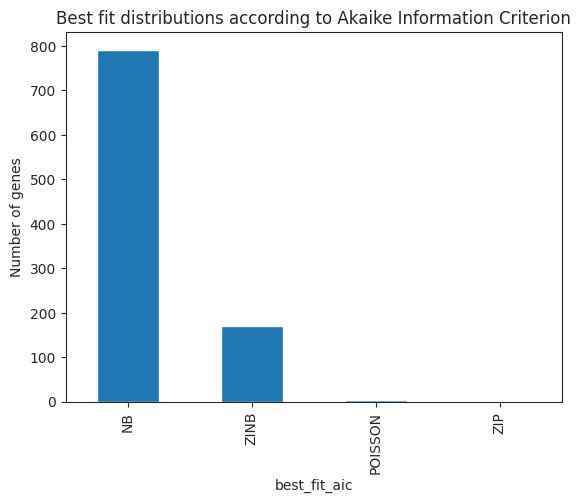

In [164]:
vc = discrete_dist_fitting_results["best_fit_aic"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Akaike Information Criterion")

Text(0.5, 1.0, 'Best fit distributions according to Kolmogorov-Smirnov test statistic')

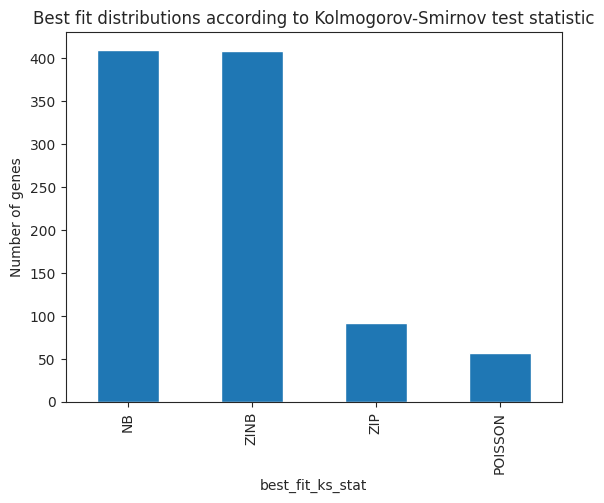

In [165]:
vc = discrete_dist_fitting_results["best_fit_ks_stat"].value_counts()
vc.plot.bar()
plt.ylabel("Number of genes")
plt.title("Best fit distributions according to Kolmogorov-Smirnov test statistic")

### Fitting continuous distributions to Gene data

In [166]:
continuous_dist_fitting_results = pd.DataFrame(index=patients_df.index, columns=["vmr", "best_fit_ks_p_val",
                                                                 "gamma_ks_stat", "gamma_ks_p_val", "gamma_alpha", "gamma_loc", "gamma_beta", 
                                                                 "lognormal_sw_stat", "lognormal_sw_p_val"
                                                                ])

In [167]:
def find_best_continuous_dist_p_value(gene: str, results: pd.DataFrame) -> Optional[str]:
    subset = results.loc[gene, ["gamma_ks_p_val", "lognormal_sw_p_val"]]
    subset = subset.dropna()
    if len(subset) == 0:
        return None
    max_p_value = subset.max()
    filt = (subset == max_p_value)
    return subset[filt].index[0].split("_")[0].upper()

for i in range(patients_df.shape[0]):
    gene = patients_df.index[i]
    row = patients_df.iloc[i, :]
    continuous_dist_fitting_results.loc[gene, "vmr"] = stds[gene]**2.0 / means[gene]
    continuous_dist_fitting_results.loc[gene, ["gamma_ks_stat", "gamma_ks_p_val", "gamma_alpha", "gamma_loc", "gamma_beta"]] = test_gamma_fit(row)
    continuous_dist_fitting_results.loc[gene, ["lognormal_sw_stat", "lognormal_sw_p_val"]] = test_lognormal_fit_sw(row)
    continuous_dist_fitting_results.loc[gene, "best_fit_p_value"] = find_best_continuous_dist_p_value(gene, continuous_dist_fitting_results)

In [168]:
continuous_dist_fitting_results["best_fit_p_value"].value_counts()

best_fit_p_value
GAMMA        858
LOGNORMAL    109
Name: count, dtype: int64

In [169]:
def sample_gamma_mean_rsd(mu: float, rel_u: float, n_points: int):
    """
    Given a mean and uncertainty % (relative standard deviation), sample from a Gamma distribution corresponding to these.
    """
    if not 0 <= rel_u <= 1:
        raise ValueError("Relative uncertainty must be between 0 and 1.")
    if mu == 0:
        mu += 1.0
    return np.random.gamma(1 / (rel_u ** 2), mu * rel_u ** 2, size=n_points)

def sample_lognormal_mean_rsd(mu: float, rel_u: float, n_points: int):
    """
    Given a mean and uncertainty % (relative standard deviation), sample from a Gamma distribution corresponding to these.
    """
    if not 0 <= rel_u <= 1:
        raise ValueError("Relative uncertainty must be between 0 and 1.")
    if mu == 0:
        mu += 1.0
    return np.random.lognormal(mean=np.log(mu) - 0.5 * np.log(1 + rel_u**2), sigma=np.sqrt(np.log(1 + rel_u**2)), size=n_points)

### Sampling from Best Fit Distributions (Subject level)

In [192]:
rsd = 0.25 # uncertainty percent
num_patients = 243
n_samples, n_features = 1000, patients_df.shape[0]

In [193]:
thres = 0.85

In [194]:
seed = 321

In [195]:
np.random.seed(seed)

- Try lognormal, gamma as fallback distributions.
- Check if fitted genes are discordant between AD and NCI (box plot, check outliers, tails)
- What if we use a "blanket" distribution for all genes?

In [196]:
gt_list, preds_list = [], []
ad_diff_cls_2, nci_diff_cls_2 = 0, 0
for j in range(num_patients):
    # Generate Monte Carlo samples
    samples = np.zeros((n_features, n_samples))

    for i in range(n_features):
        gene = patients_df.index[i]
        mean = patients_df.iloc[i, j] 
        
        # Pick the best distribution for each gene based on a suitable criterion
        # best_dist = discrete_dist_fitting_results.loc[gene, "best_fit_aic"]
        best_dist = "NB"
        
        # Check for VMR as well.
        
        # Generate samples from the best fit continuous distribution if a distribution with the specified uncertainty and mean
        # is impossible to sample from.
        if rsd ** 2.0 <= 1/mean:
            # logging.warning(f"Could not find a suitable {best_dist} distribution.")
            best_dist = continuous_dist_fitting_results.loc[gene, "best_fit_p_value"]
            # logging.warning(f"Falling back to {best_dist}.")
        
        # Sample from distribution
        match best_dist:
            case "NB":
                samples[i] = sample_negative_binomial_mean_rsd(mean, rsd, n_samples)
            case "LOGNORMAL":
                samples[i] = sample_lognormal_mean_rsd(mean, rsd, n_samples)
            case "GAMMA":
                samples[i] = sample_gamma_mean_rsd(mean, rsd, n_samples)
            # case "POISSON":
                # samples[i] = sample_poisson_mean_rsd(mean, rsd, n_samples)
            # case "ZIP":
                # samples[i] = sample_zero_inflated_poisson_mean_rsd(mean, rsd, n_samples)
            # case "ZINB":
                # samples[i] = sample_zero_inflated_negative_binomial_mean_rsd(mean, rsd, discrete_dist_fitting_results.loc[gene, "zinb_pi"], n_samples)

    # Convert sampled TPMs to z-scores
    samples = z_score(samples,  means.values[:n_features, np.newaxis], stds.values[:n_features, np.newaxis])

    # Get predicted probabilities from z-scores
    pred_probs = antilogit_classifier_score(linear_classifier_score(coefficients[:n_features, np.newaxis], samples))

    # Get ground truth probabilities from original TPMs
    tpm_z_scores = z_score(patients_df.iloc[:, j], means[:n_features], stds[:n_features])
    gt_prob = antilogit_classifier_score(linear_classifier_score(coefficients, tpm_z_scores))
    gt_label = 0 if gt_prob < thres_1 else 1
    
    preds = np.zeros(n_samples, dtype=np.int64)
    preds[(thres <= pred_probs)] = 1 

    if gt_label == 0 and 1 in preds:
        ad_diff_cls_2 += 1
    if gt_label == 1 and 0 in preds:
        nci_diff_cls_2 += 1
    
    gt_arr = np.ones(n_samples, dtype=np.int64) * gt_label
    gt_list.append(gt_arr)
    preds_list.append(preds)

In [197]:
preds_all = np.hstack(preds_list)
gt_all = np.hstack(gt_list)

In [200]:
cnf_mat = confusion_matrix(gt_all, preds_all)

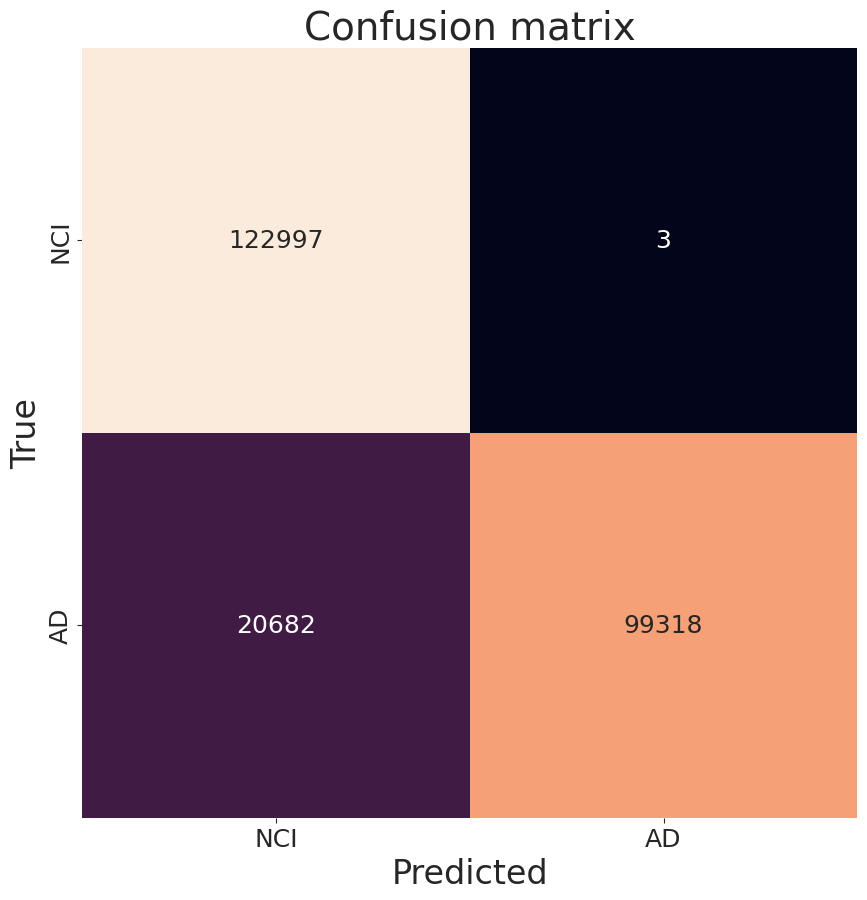

In [201]:
cnf_mat_df = pd.DataFrame(cnf_mat.astype(np.int64), index=["NCI", "AD"], columns=["NCI", "AD"])
plt.figure(figsize=(10, 10))
plt.title("Confusion matrix", fontsize=28)
sns.heatmap(cnf_mat_df, annot=True, cbar=False, fmt="g", annot_kws={"size": 18})
plt.tick_params(labelsize=18)
plt.xlabel("Predicted", fontsize=24)
plt.ylabel("True", fontsize=24)
plt.show()